#AULA 2

---

Machine Learning e Deep Learning com Kaggle

## KAGGLE
https://www.kaggle.com/
---
![](https://minerandodados.com.br/wp-content/uploads/2018/03/kaggle-problem.png)
<br>Plataforma comprada pela Google para competições de Machine Learning(prêmios em dinheiro), repositório de datasets, Notebooks explicados e comunidade global.

### MODELO PREDITIVO(TREINO)

---

Qual algoritmo usar?!
<br><br>
![](https://scikit-learn.org/stable/_static/ml_map.png)

## PROJETO: CLASSIFICAÇÃO(DEEP LEARNING)
https://www.kaggle.com/uciml/sms-spam-collection-dataset

### AQUISIÇÃO DE DADOS

In [ ]:
# BIBLIOTECAS
import random
import spacy
import pandas as pd
import seaborn as sns
from spacy.util import minibatch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

In [ ]:
# dados
data_path = "https://raw.githubusercontent.com/qodatecnologia/spam-data/main/spam-data.csv"
data = pd.read_csv(data_path)
print(data.head())

     v1  ... Unnamed: 4
0   ham  ...        NaN
1   ham  ...        NaN
2  spam  ...        NaN
3   ham  ...        NaN
4   ham  ...        NaN

[5 rows x 5 columns]


### ANÁLISE EXPLORATÓRIA DE DADOS

In [ ]:
data = pd.read_csv(data_path)
observations = len(data.index)
print(f"Tamanho do Dataset: {observations}\n")
print(data['v1'].value_counts())
print()
print(data['v1'].value_counts() / len(data.index) * 100.0)

Tamanho do Dataset: 5572

ham     4825
spam     747
Name: v1, dtype: int64

ham     86.593683
spam    13.406317
Name: v1, dtype: float64


###PASSO 3: PIPELINE SPACY


---
Para construir modelos com Spacy, você pode carregar os modelos de pipeline existentes ou criar um modelo vazio e adicionar as etapas de modelagem. Na 1ª linha, criamos o modelo vazio com spacy e passamos o idioma do dataset que é o inglês (en). Nas próximas linhas, estamos criando um pipeline dizendo que precisamos que esse modelo execute a classificação do texto. Utilizamos a arquitetura “bow” que, basicamente, executa “bag of words”. Em seguida, estamos adicionando o pipeline “text_cat” criado ao nosso modelo vazio. Nesta fase estamos tendo um modelo e estamos dizendo que este modelo deve realizar a classificação do texto utilizando a abordagem “bow”. Em seguida, estamos adicionando as classes target spam e ham ao modelo de categorização de texto criado. Não estamos executando nenhuma técnica de pré-processamento de texto com NLP pois foge do escopo deste tutorial e principalmente por recebermos o dataset já tratado: o que é raro no mundo real.


In [ ]:
# Criamos um modelo vazio com o idioma do dataset
nlp = spacy.blank("en")

# Criamos agora um classificador de texto com classes exclusivas + arquitetura "bow" 
text_cat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})

# Adicionamos o classificador a nosso modelo vazio
nlp.add_pipe(text_cat)

# Adicionamos as "classes exclusivas"
text_cat.add_label("ham")
text_cat.add_label("spam")

1

###TREINO/TESTE

---
Vamos dividir os dados carregados em TREINO/TESTE.

Conjunto de dados de treinamento: para treinar o modelo de categorização de texto.
Conjunto de dados de teste: para validar o desempenho do modelo.

Para dividir os dados em 2 conjuntos de dados, usaremos o train_test_split do scikit learn, de forma que os dados de teste representem 33% dos dados carregados.


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
      data['v2'], data['v1'], test_size=0.33, random_state=7)

Ao contrário dos outros modelos do scikit-learn, você não pode passar o destino como uma única coluna para o spacy, precisamos criar explicitamente os destinos como uma lista booleana de True/False. Como para cada texto de e-mail, o target é True. Criamos onehot encoding para categorias target(o que queremos prever), onde estamos criando dois rótulos booleanos(True/False) e atribuindo True para o rótulo real e False para o outro rótulo. Agora temos features e targets para treinar o modelo, mas primeiro precisamos combinar as features e os targets em um único conjunto de dados para construir o modelo de classificação de e-mail. Estamos pegando as features (texto do e-mail), convertendo rótulos de treino (booleanos) e juntando-os usando o método zip, a mesma abordagem que estamos aplicando para conjuntos de dados de treinamento e teste.

In [ ]:
train_lables = [{'cats': {'ham': label == 'ham',
                          'spam': label == 'spam'}}  for label in y_train]

test_lables = [{'cats': {'ham': label == 'ham',
                      'spam': label == 'spam'}}  for label in y_test]

# Spacy model data
train_data = list(zip(x_train, train_lables))
test_data = list(zip(x_test, test_lables))

Para cada época, estamos embaralhando os dados usando o método de embaralhamento “shuffle” e, em seguida, criando os batches(lotes de treinamento). 

Para cada lote atualizamos o modelo usando o otimizador e, no final, capturamos as loss functions.

* model: modelo vazio já criado
* train data: dados de treino
* optimizer: Otimizador
* batch size: Tamanho dos batches
* epochs: épocas de treinamento

In [ ]:
def train_model(model, train_data, optimizer, batch_size, epochs=10):
    losses = {}
    random.seed(1)

    for epoch in range(epochs):
        random.shuffle(train_data)

        batches = minibatch(train_data, size=batch_size)
        for batch in batches:
            # Split batch into texts and labels
            texts, labels = zip(*batch)

            # Update model with texts and labels
            model.update(texts, labels, sgd=optimizer, losses=losses)
        print("Loss: {}".format(losses['textcat']))

    return losses['textcat']

In [ ]:
optimizer = nlp.begin_training()
batch_size = 5
epochs = 10

# Treinar!
train_model(nlp, train_data, optimizer, batch_size, epochs)

Loss: 3.9675071447882146
Loss: 4.947752934833176
Loss: 5.475570609709221
Loss: 5.8221963234604885
Loss: 6.054016676907645
Loss: 6.198435771319279
Loss: 6.297653178926925
Loss: 6.367637058164786
Loss: 6.424966427345702
Loss: 6.471268548712159


6.471268548712159

###PASSO 5: PREDIÇÕES

---


Para o texto de sms/e-mail abaixo, a saída real é “ham” e nosso modelo está tendo alta probabilidade de quase 99% para ham e 1% para spam. O que significa que nosso modelo está prevendo o texto do e-mail corretamente.

In [ ]:
print(train_data[0])
sample_test = nlp(train_data[0][0])
print(sample_test.cats)

('Remember all those whom i hurt during days of satanic imposter in me.need to pay a price,so be it.may destiny keep me going and as u said pray that i get the mind to get over the same.', {'cats': {'ham': True, 'spam': False}})
{'ham': 0.9999992847442627, 'spam': 7.569625495307264e-07}


A função abaixo “get_predictions” usa dois parâmetros, um é o modelo e o outro é o texto da sms. Na 3ª linha da função, o texto é tokenizado e, em seguida, dividimos o conteúdo da sms e armazenamos em documentos. Nas próximas linhas chamamos o método “textcat” que criamos, usando o objeto textcat para prever a classe de spam ham/spam. As Pontuações basicamente fornecem as probabilidades para ambas as classes. Para identificar a classe de rótulo, estamos pegando a probabilidade máxima usando o argmax, então estamos retornando as previsões.

In [ ]:
def get_predictions(model, texts):
    # Tokenizar
    docs = [model.tokenizer(text) for text in texts]

    # textcat para verificar os scores
    textcat = model.get_pipe('textcat')
    scores, _ = textcat.predict(docs)

    # Mostramos os scores mais altos com argmax
    predicted_labels = scores.argmax(axis=1)
    predicted_class = [textcat.labels[label] for label in predicted_labels]

    return predicted_class

### AVALIAÇÃO DO MODELO

---

Para problemas supervisionados de classificação, podemos/devemos utilizar acurácia e a matriz de confusão.

In [ ]:
# ACURÁCIA
train_predictions = get_predictions(nlp, x_train)
test_predictions = get_predictions(nlp, x_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Train accuracy: 0.998928475756764
Test accuracy: 0.9815116911364872


uau! 99% no treino e 98% nos testes: muito bom! Acreditamos que a missão por aqui foi cumprida, mas ainda falta uma última etapa: a matriz de confusão para treino e teste:

TREINO:


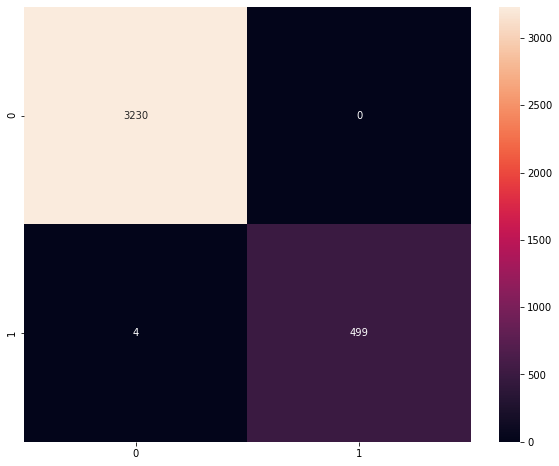

In [ ]:
# MATRIZ DE CONFUSÃO TREINO
print("TREINO:")
cf_train_matrix = confusion_matrix(y_train, train_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_train_matrix, annot=True, fmt='d')

TESTE:


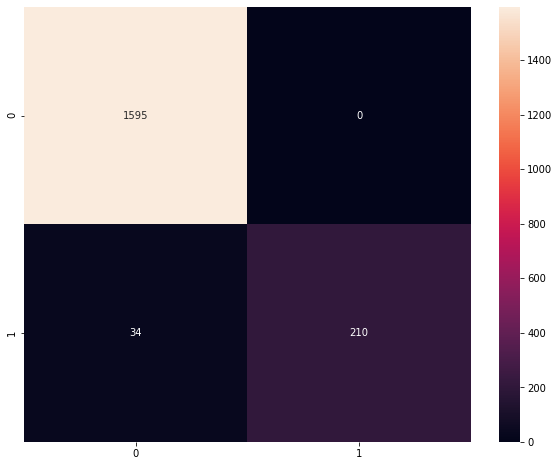

In [ ]:
# MATRIZ DE CONFUSÃO TESTE
print("TESTE:")
cf_test_matrix = confusion_matrix(y_test, test_predictions)
plt.figure(figsize=(10,8))
sns.heatmap(cf_test_matrix, annot=True, fmt='d')

## PROJETO 3: CRIANDO DATA APP 

---

Este app precisa ser criado em sua máquina local, por isto, efetue download deste .jpynb
<br>Dataset em .txt: https://gist.github.com/qodatecnologia/1fa12c3b4820435cc4f899e8e4610e4e#file-smsspamcollection-txt

In [ ]:
'''
functions.py
'''

#no need to change anything in this file!

#SMS Spam Filter Imports
import random
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')

def categorize_words():
    '''
    Catagorizes each spam/non-spam word into a corresponding list
    Repeating words in each list will help with categorizing
    '''
    spam_words = []
    ham_words = []
    for sms in data['processed'][data['label'] == 'spam']:
        for word in sms:
            spam_words.append(word)
    for sms in data['processed'][data['label'] == 'ham']:
        for word in sms:
            ham_words.append(word)
    return spam_words, ham_words

def predict(user_input):
  spam_counter = 0
  ham_counter = 0

  #add text colour : ham is green, spam is red
  red = [220,50,50]
  green = [100,220,50]

  for word in user_input:
    spam_counter += spam_words.count(word)
    ham_counter += ham_words.count(word)

  if ham_counter > spam_counter:
    #adding accuracy
    certainty = round((ham_counter / (ham_counter + spam_counter)) * 100, 2)
    return 'Não é spam, com {}% de certeza'.format(certainty), green
  elif spam_counter > ham_counter:
    certainty = round((spam_counter / (ham_counter + spam_counter)) * 100, 2)
    return 'Spam, com {}% de certeza'.format(certainty), red
  else:
    return 'Pode ser, ou não, estou na dúvida com 50% de certeza', [255,255,255]

def pre_process(sms):
    '''
    Remove punctuation and stop words from the custom sms
    '''
    remove_punct = "".join([word.lower() for word in sms if word not in string.punctuation])
    tokenize = nltk.tokenize.word_tokenize(remove_punct)
    remove_stop_words = [word for word in tokenize if word not in nltk.corpus.stopwords.words('english')]
    return remove_stop_words

data = pd.read_csv('SMSSpamCollection.txt', sep = '\t', header=None, names=["label", "sms"])
data['processed'] = data['sms'].apply(lambda x: pre_process(x))

#creating lists to store spam/non-spam associated words and their instances
spam_words, ham_words = categorize_words()


In [ ]:
''' 
app.py
'''

#DearPyGUI Imports
from dearpygui.core import *
from dearpygui.simple import *

#functions.py Imports
from functions import categorize_words, pre_process, predict

pred = []
#button callbak function
#runs each time when the "Check" button is clicked
def check_spam(pred):
    with window("Simple SMS Spam Filter"):
        if pred == []:
            #runs only once - the the button is first clicked
            #and pred[-1] widget doesn't exist
            add_spacing(count=12)
            add_separator()
            add_spacing(count=12)
        else:
            #hide prediction widget
            hide_item(pred[-1])
        #collect input, pre-process and get prediction
        input_value = get_value("Input")
        input_value = pre_process(input_value)
        pred_text, text_colour = predict(input_value)
        #store prediction inside the pred list
        pred.append(pred_text)
        #display prediction to user
        add_text(pred[-1], color=text_colour)

#window object settings
set_main_window_size(540, 720)
set_global_font_scale(1.25)
set_theme("Gold")
set_style_window_padding(30,30)

with window("Simple SMS Spam Filter", width=520, height=677):
    print("GUI is running...")
    set_window_pos("Simple SMS Spam Filter", 0, 0)

    #image logo
    add_drawing("logo", width=520, height=290) #create some space for the image

    add_separator()
    add_spacing(count=12)
    #text instructions
    add_text("Por favor, digite uma mensagem SMS de sua escolha para verificar se é spam ou não",
    color=[232,163,33])
    add_spacing(count=12)
    #collect input
    add_input_text("Input", width=415, default_value="Escreva aqui!")
    add_spacing(count=12)
    #action button
    add_button("Verificar", callback=lambda x,y:check_spam(pred))

#place the image inside the space
draw_image("logo", "logo_spamFilter.png", [0, 240])

#IF THE PREVIOUS LINE OF CODE TRIGGERS AN ERRROR TRY
#draw_image("logo", "logo_spamFilter.png", [0,0], [458,192])

start_dearpygui()
print("Bye Bye, GUI")


# DISCLAIMER

---

Ao término das aulas, abriremos uma nova turma para a MARATONA DATA SCIENCE(360h), contendo 12 cursos de 30h cada. Abriremos 256 vagas apenas com acesso vitalício. Preço pandemia: R$123,00

<br>Maiores infos em: https://qoda.com.br/maratona-data-science-by-qoda/
<br>Grupo para vagas antecipadas: https://chat.whatsapp.com/Bwtucly0YfDF2hSFnvD67E 
<br><br>
![alt](https://uploaddeimagens.com.br/images/003/138/338/original/trilha.png?1616075260)